In [3]:
import numpy as np
import pandas as pd
import pydicom
from matplotlib import pyplot as plt
import os
from mask_functions import rle2mask, mask2rle
from google.cloud import storage

In [4]:
bucket = storage.Client().get_bucket("pneumothorax_chest_x-rays")

In [5]:
blobs = list(bucket.list_blobs(prefix='test/'))

In [6]:
df = pd.read_csv('./output/sample_submission.csv')
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6067.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6214.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6177.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6655.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6359.151787519...,-1


In [7]:
import torch
import torch.utils.data
import collections
from tqdm import tqdm_notebook
from PIL import Image
import torchvision

class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, blobs, df):
        self.blobs = blobs
        self.df = df
        
        self.image_info = collections.defaultdict(dict)
        
        i = 0
        for blob in tqdm_notebook(self.blobs):
            file_path = blob.name
            img_id = file_path.split('/')[-1][:-4]
            
            # skip the img_ids which are out of sample df
            df_temp = self.df.loc[self.df.ImageId == img_id]
            if not df_temp.iloc[0, 0]:
                continue
            
            dcm_path = './testset/{}.dcm'.format(img_id)
            png_path = './testset_png/{}.png'.format(img_id)
                
            # if the dcm is not downloaded, download it.
            if not os.path.exists(dcm_path):
                with open(dcm_path, 'wb') as file_obj:
                    blob.download_to_file(file_obj)  
            # if the png is not created, create it.
            if not os.path.exists(png_path):
                with open(png_path, 'wb') as file_obj:
                    dcm_data = pydicom.dcmread(dcm_path) #, force=True)  
                    img = dcm_data.pixel_array
                    img_mem = Image.fromarray(img)
                    img_mem.save(file_obj)
                
            self.image_info[i]["image_id"] = img_id
            self.image_info[i]["image_path"] = png_path
            i += 1
                
            
    def __getitem__(self, idx):
        # images
        img_path = self.image_info[idx]["image_path"]
        img = Image.open(img_path).convert("RGB")
        tsr = torchvision.transforms.ToTensor()(img)
        
#         # resize
#         tsr = img.resize((256, 256), resample=Image.BILINEAR)
#         tsr = torchvision.transforms.ToTensor()(tsr)

        return img, tsr, self.image_info[idx]["image_id"]
    

    def __len__(self):
        return len(self.image_info)

In [25]:
testset = TorchDataset(blobs, df)

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)

# load the trained parameter
model.load_state_dict(torch.load('./model/model_para.pt'))
# model.load_state_dict(torch.load('./model/model.bin'))

# move model to the right device
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
    

In [11]:
# pick one image from the test set
img, tsr, img_id = testset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([tsr.to(device)])

In [12]:
prediction

[{'boxes': tensor([[738.3564, 686.0402, 947.3710, 820.5953],
          [653.8806, 166.7901, 868.2126, 315.7506],
          [645.6188, 170.7451, 819.5466, 261.4549],
          [291.6364, 157.6022, 480.4015, 247.2645],
          [636.6669, 165.9051, 903.5880, 420.8497],
          [329.5251, 157.8419, 483.0401, 212.4015],
          [721.7000, 547.8616, 958.2328, 846.8204],
          [794.3271, 730.5885, 942.1921, 818.4711],
          [660.4969, 170.4238, 785.6829, 225.6550]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9118, 0.5199, 0.4351, 0.2853, 0.1884, 0.1615, 0.1222, 0.0736, 0.0633],
         device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0.,

In [13]:
scores = prediction[0]['scores']
scores

tensor([0.9118, 0.5199, 0.4351, 0.2853, 0.1884, 0.1615, 0.1222, 0.0736, 0.0633],
       device='cuda:0')

In [14]:
scores_binary = (scores >0.3)
scores_binary

tensor([1, 1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.uint8)

In [15]:
scores_binary.all == 0

False

In [16]:
scores = prediction[0]['scores']
scores_binary = (scores >= 0.3)

# no score/mask or all the scores <0.3
if len(scores) ==0 or scores_binary.all == 0:
    rle = '-1'

else:
    masks = prediction[0]['masks'].mul(255).byte().cpu().numpy()
    mask_pred = np.zeros_like(masks[0, 0]).astype(np.uint64) #change type to prevent overflow
    for i, binary in enumerate(scores_binary):
        if binary ==1:
            mask_pred += masks[i, 0]
    mask_pred = (mask_pred > 127).astype(np.uint8)
    mask_pred = np.where(mask_pred ==0, 0, 255)
    rle = mask2rle(mask_pred.T, 1024, 1024)
    
#     # resize
#     mask_temp = Image.fromarray(mask_pred).resize((1024, 1024), resample=Image.BILINEAR)
#     mask_temp = np.array(mask_temp)
#     rle = mask2rle(mask_temp.T, 1024, 1024)
    
    if rle == '':
        rle = '-1'

In [17]:
rle

'663788 13 1010 15 1002 24 994 32 989 36 985 40 982 43 978 48 973 52 970 54 969 56 965 59 963 61 962 62 960 65 957 67 949 3 3 69 947 6 1 70 943 81 942 83 940 84 940 84 939 86 937 89 935 91 931 94 929 95 929 95 928 96 928 96 927 97 927 97 926 98 926 97 927 96 928 96 928 95 929 92 932 92 932 92 931 93 931 92 932 92 932 92 932 92 932 91 933 91 933 91 933 90 934 90 934 90 934 89 935 89 935 88 935 89 935 88 936 88 936 87 937 85 939 82 942 80 944 78 946 77 947 68 5 3 948 68 957 67 957 67 957 67 957 67 957 66 958 66 958 66 958 65 959 65 959 65 959 64 960 64 960 64 960 63 961 62 962 62 962 61 964 59 965 59 965 59 965 58 966 58 966 57 968 56 968 56 968 55 969 55 969 55 550 12 408 53 549 16 406 53 548 16 407 53 547 17 407 53 546 18 408 52 544 19 409 52 543 20 409 52 542 21 410 50 542 22 410 50 541 22 411 50 540 22 413 49 539 23 413 49 538 23 414 49 537 24 415 48 537 24 415 48 536 24 416 48 535 25 417 47 534 25 419 46 533 26 419 46 532 26 421 45 531 27 421 45 530 27 423 44 530 27 423 44 529 27 42

In [18]:
mask_0 = np.zeros((1024, 1024))
mask_0 = np.uint8(mask_0)

In [19]:
rle_0 = mask2rle(mask_0.T, 1024, 1024)
rle_0

''

In [20]:
np.unique(rle2mask(rle_0, 1024, 1024).T)

array([0.])

In [21]:
mask_rle = rle2mask(rle, 1024, 1024).T
mask_rle = np.uint8(mask_rle)

In [22]:
np.unique(mask_rle)

array([  0, 255], dtype=uint8)

In [23]:
np.unique(mask_pred)

array([  0, 255])

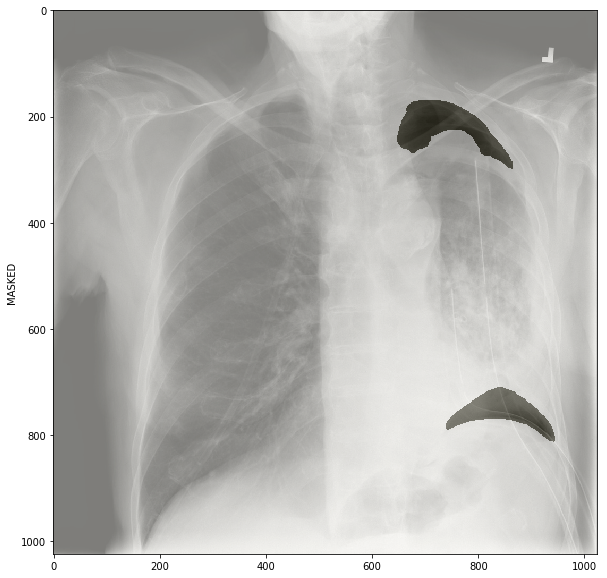

In [24]:
plt.figure(figsize=(10,10))
plt.ylabel('MASKED')

plt.imshow(img, cmap=plt.cm.bone)
plt.imshow(mask_pred, alpha=0.3, cmap="Reds")
# plt.imshow(mask_temp, alpha=0.3, cmap="Greens")
plt.imshow(mask_rle, alpha=0.3, cmap="Greens")

In [ ]:
# predict on the entire test set
# put the model in evaluation mode
model.eval()

with torch.no_grad():
    test_list = list()
    
    for i in tqdm(range(len(testset))):
        img, tsr, img_id = testset[i]
        prediction = model([tsr.to(device)])
###
        scores = prediction[0]['scores']
        scores_binary = (scores >= 0.3)

        # no score/mask or all the scores <0.3
        if len(scores) ==0 or scores_binary.all == 0:
            rle = '-1'

        else:
            masks = prediction[0]['masks'].mul(255).byte().cpu().numpy()
            mask_pred = np.zeros_like(masks[0, 0]).astype(np.uint64) #change type to prevent overflow
            for i, binary in enumerate(scores_binary):
                if binary ==1:
                    mask_pred += masks[i, 0]
            mask_pred = (mask_pred > 127).astype(np.uint8)
            mask_pred = np.where(mask_pred ==0, 0, 255)
            rle = mask2rle(mask_pred.T, 1024, 1024)

        #     # resize
        #     mask_temp = Image.fromarray(mask_pred).resize((1024, 1024), resample=Image.BILINEAR)
        #     mask_temp = np.array(mask_temp)
        #     rle = mask2rle(mask_temp.T, 1024, 1024)

            if rle == '':
                rle = '-1'
###
    
        test_list.append([img_id, rle])

In [ ]:
sample_order = list(df['ImageId'])

In [ ]:
pred_list = [tuple for x in sample_order for tuple in test_list if tuple[0] == x]

In [ ]:
df_pred = pd.DataFrame(pred_list, columns = df.columns.values) 

In [ ]:
df_pred.to_csv('./output/submission.csv', index=False)